![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

$\gamma (\mathbf{v})$.

- No mapping: $\gamma(\mathbf{v})= \mathbf{v}$.

- Basic mapping: $\gamma(\mathbf{v})=\left[ \cos(2 \pi \mathbf{v}),\sin(2 \pi \mathbf{v}) \right]^\mathrm{T}$.

- Gaussian Fourier feature mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$,
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $\mathcal N(0,\sigma^2)$.


### Imports

In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, imageio
import cv2
import numpy as np

# imports /content/assignment2/models/neural_net.py if you mounted correctly
from models.neural_net import NeuralNetwork

# makes sure your NeuralNetwork updates as you make changes to the .py file
%load_ext autoreload
%autoreload 2

# sets default size of plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

## Helper Functions

### Image Data and Feature Mappings

In [ ]:
# Data loader
def get_image(size=512, \
              image_url='https://bmild.github.io/fourfeat/img/lion_orig.png'):

  # Downloading image, taking a square crop from the center
  img = imageio.imread(image_url)[..., :3] / 255.
  c = [img.shape[0]//2, img.shape[1]//2]
  r = 256
  img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

  if size != 512:
    img = cv2.resize(img, (size, size))

  plt.imshow(img)
  plt.show()

  # Creating input pixel coordinates in the unit square
  coords = np.linspace(0, 1, img.shape[0], endpoint=False)
  x_test = np.stack(np.meshgrid(coords, coords), -1)
  test_data = [x_test, img]
  train_data = [x_test[::2, ::2], img[::2, ::2]]

  return train_data, test_data

In [ ]:
# Creating the mappings dictionary of matrix B -  you will implement this
def get_B_dict(size):
  mapping_size = size // 2 # you may tweak this hyperparameter
  B_dict = {}
  B_dict['none'] = None

  # adding B matrix for basic, gauss_1.0
  B_dict["basic"] = np.identity(2)
  B_dict["gauss_1.0"] = np.random.normal(loc = 0, scale = 1.0, size = (mapping_size,2))

  return B_dict

In [ ]:
# Given tensor x of input coordinates, lets map it using B
def input_mapping(x, B):
  if B is None:
    # "none" mapping - just returns the original input coordinates
    return x
  else:
    # "basic" mapping and "gauss_X" mappings project input features using B
    # return np.array()
    first = np.cos(np.matmul(x, np.transpose(B)))
    second = np.sin(np.matmul(x, np.transpose(B)))
    # print(x.shape, B.shape, first.shape, second.shape)
    return np.concatenate((first, second), axis=1)

### MSE Loss and PSNR Error

In [ ]:
def mse(y, p):
  return np.sum((y - p)**2)/(y.shape[0]*y.shape[1])

def psnr(y, p):
  return 10 * np.log10(1/mse(y,p))

<ipython-input-4-47d50880e2e8>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


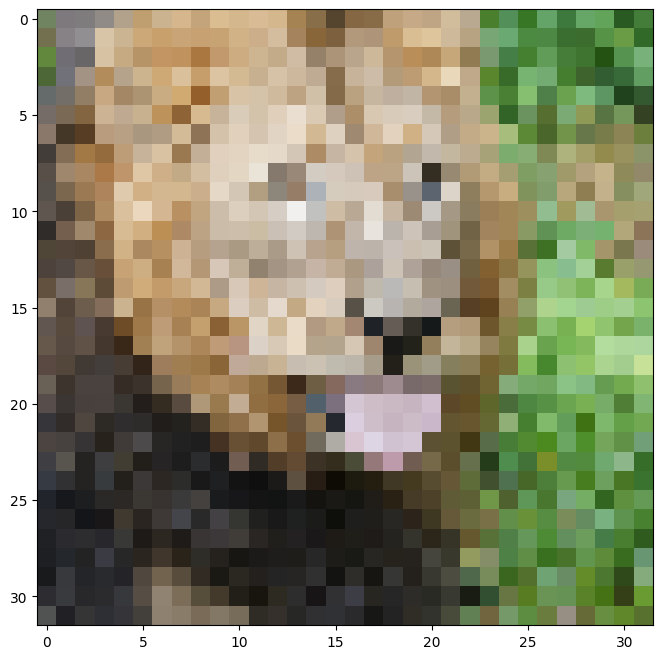

In [ ]:
size = 32
train_data, test_data = get_image(size)

Some suggested hyperparameter choices to help you start
- hidden layer count: 4
- hidden layer size: 256
- number of epochs: 1000
- learning rate: 1e-4


In [ ]:
num_layers = 5
hidden_size = 256
# hidden_sizes = [hidden_size] * (num_layers - 1)
hidden_sizes = [32,128,512,512]
epochs = 3000
learning_rate = 3e-4
output_size = 3
B_dict = get_B_dict(size)

print('B_dict items:')
for k,v in B_dict.items():
    print('\t',k,np.array(v).shape)

B_dict items:
	 none ()
	 basic (2, 2)
	 gauss_1.0 (16, 2)


In [ ]:
# Applying the input feature mapping to the train and test data 
def get_input_features(B_dict, mapping):
  # mapping is the key to the B_dict, which has the value of B
  # B is then used with the function `input_mapping` to map x
  y_train = train_data[1].reshape(-1, output_size)
  y_test = test_data[1].reshape(-1, output_size)
  X_train = input_mapping(train_data[0].reshape(-1, 2), B_dict[mapping])
  X_test = input_mapping(test_data[0].reshape(-1, 2), B_dict[mapping])
  return X_train, y_train, X_test, y_test

### Plotting and video helper functions

In [ ]:
def plot_training_curves(train_loss, train_psnr, test_psnr):
  # plot the training loss
  plt.subplot(2, 1, 1)
  plt.plot(train_loss)
  plt.title('MSE history')
  plt.xlabel('Iteration')
  plt.ylabel('MSE Loss')

  # plot the training and testing psnr
  plt.subplot(2, 1, 2)
  plt.plot(train_psnr, label='train')
  plt.plot(test_psnr, label='test')
  plt.title('PSNR history')
  plt.xlabel('Iteration')
  plt.ylabel('PSNR')
  plt.legend()

  plt.tight_layout()
  plt.show()

def plot_reconstruction(p, y):
  p_im = p.reshape(size,size,3)
  y_im = y.reshape(size,size,3)

  plt.figure(figsize=(12,6))

  # plot the reconstruction of the image
  plt.subplot(1,2,1), plt.imshow(p_im), plt.title("reconstruction")

  # plot the ground truth image
  plt.subplot(1,2,2), plt.imshow(y_im), plt.title("ground truth")

  print("Final Test MSE", mse(y, p))
  print("Final Test psnr",psnr(y, p))

def plot_reconstruction_progress(predicted_images, y, N=8):
  total = len(predicted_images)
  step = total // N
  plt.figure(figsize=(24, 4))

  # plot the progress of reconstructions
  for i, j in enumerate(range(0,total, step)):
      plt.subplot(1, N, i+1)
      plt.imshow(predicted_images[j].reshape(size,size,3))
      plt.axis("off")
      plt.title(f"iter {j}")

  # plot ground truth image
  plt.subplot(1, N+1, N+1)
  plt.imshow(y.reshape(size,size,3))
  plt.title('GT')
  plt.axis("off")
  plt.show()

def plot_feature_mapping_comparison(outputs, gt):
  # plot reconstruction images for each mapping
  plt.figure(figsize=(24, 4))
  N = len(outputs)
  for i, k in enumerate(outputs):
      plt.subplot(1, N+1, i+1)
      plt.imshow(outputs[k]['pred_imgs'][-1].reshape(size, size, -1))
      plt.title(k)
  plt.subplot(1, N+1, N+1)
  plt.imshow(gt)
  plt.title('GT')
  plt.show()

  # plot train/test error curves for each mapping
  iters = len(outputs[k]['train_psnrs'])
  plt.figure(figsize=(16, 6))
  plt.subplot(121)
  for i, k in enumerate(outputs):
      plt.plot(range(iters), outputs[k]['train_psnrs'], label=k)
  plt.title('Train error')
  plt.ylabel('PSNR')
  plt.xlabel('Training iter')
  plt.legend()
  plt.subplot(122)
  for i, k in enumerate(outputs):
      plt.plot(range(iters), outputs[k]['test_psnrs'], label=k)
  plt.title('Test error')
  plt.ylabel('PSNR')
  plt.xlabel('Training iter')
  plt.legend()
  plt.show()

# Save out video
def create_and_visualize_video(outputs, size=size, epochs=epochs, filename='training_convergence.mp4'):
  all_preds = np.concatenate([outputs[n]['pred_imgs'].reshape(epochs,size,size,3)[::25] for n in outputs], axis=-2)
  data8 = (255*np.clip(all_preds, 0, 1)).astype(np.uint8)
  f = os.path.join(filename)
  imageio.mimwrite(f, data8, fps=20)

  # Display video inline
  from IPython.display import HTML
  from base64 import b64encode
  mp4 = open(f, 'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

  N = len(outputs)
  if N == 1:
    return HTML(f'''
    <video width=256 controls autoplay loop>
          <source src="{data_url}" type="video/mp4">
    </video>
    ''')
  else:
    return HTML(f'''
    <video width=1000 controls autoplay loop>
          <source src="{data_url}" type="video/mp4">
    </video>
    <table width="1000" cellspacing="0" cellpadding="0">
      <tr>{''.join(N*[f'<td width="{1000//len(outputs)}"></td>'])}</tr>
      <tr>{''.join(N*['<td style="text-align:center">{}</td>'])}</tr>
    </table>
    '''.format(*list(outputs.keys())))

### Experiment Runner

In [ ]:
def NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                  hidden_size, hidden_sizes, output_size, epochs,\
                  learning_rate, opt):

    # Initializing a new neural network model
    net = NeuralNetwork(input_size, hidden_sizes, output_size, num_layers, opt)

    # Variables to store performance for each epoch
    train_loss = np.zeros(epochs)
    train_psnr = np.zeros(epochs)
    test_psnr = np.zeros(epochs)
    predicted_images = np.zeros((epochs, y_test.shape[0], y_test.shape[1]))
    # print(X_train.shape)
    init_lr = learning_rate
    cur_lr = init_lr

    temp = np.concatenate((X_train, y_train), axis=1)
    # For each epoch...
    for epoch in tqdm(range(epochs)):

      np.random.shuffle(temp)

      # Training

      net.forward(temp[:,0:X_train.shape[1]])
      # print("Forward ", epoch, "done")

      train_psnr[epoch] = psnr(temp[:, X_train.shape[1]:], net.outputs["OutSig"])
      # print("PSNR ", epoch, "done")

      train_loss[epoch] = net.backward(temp[:, X_train.shape[1]:])
      # if epoch > 600:
      #   cur_lr = init_lr * np.exp(-1 *0.009*(epoch - 1500))
      net.update(lr = cur_lr, opt = opt)
      # Testing

      predicted_images[epoch] = net.forward(X_test)
      test_psnr[epoch] = psnr(y_test, predicted_images[epoch])

    return net, train_psnr, test_psnr, train_loss, predicted_images

# Low Resolution Reconstruction

#### Low Resolution Reconstruction - SGD - None Mapping

  0%|          | 0/4000 [00:00<?, ?it/s]

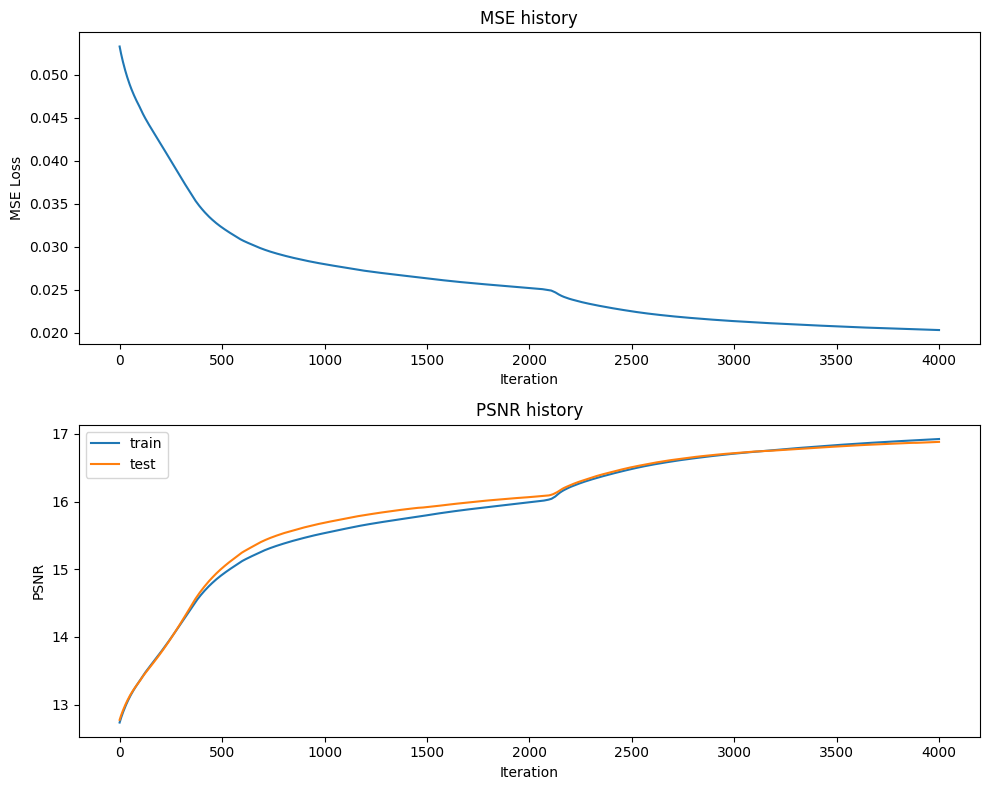

Final Test MSE 0.020496772827201252
Final Test psnr 16.883145122938966


<ipython-input-130-afe762edcc7f>:49: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, N+1, N+1)


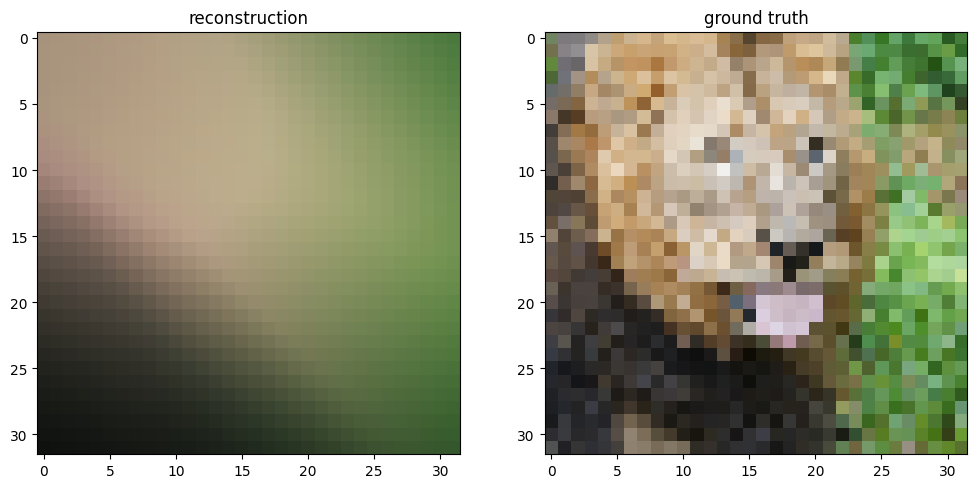

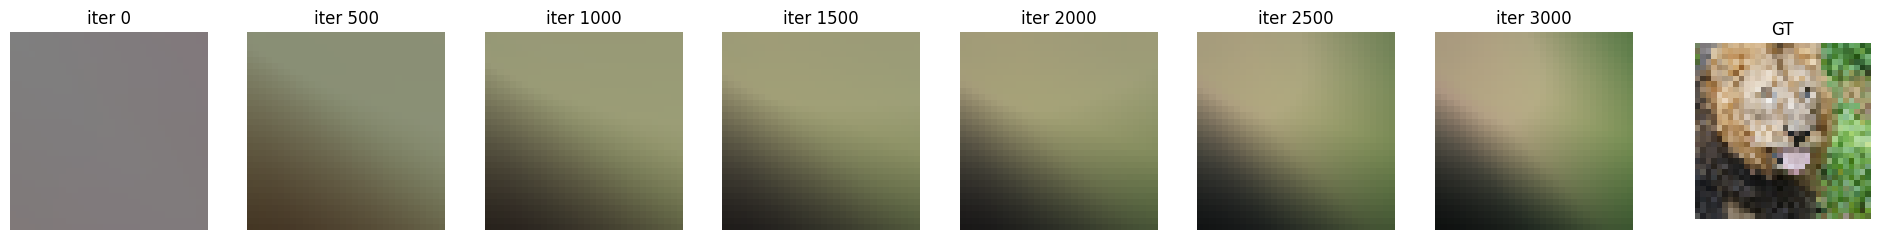

In [ ]:
# get input features
b_dict = get_B_dict(size)
# print(output_size)
# print(train_data[1].reshape(-1, output_size))
X_train, y_train, X_test, y_test = get_input_features(b_dict, "none")
# run NN experiment on input features
net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, 2, num_layers, hidden_size, hidden_sizes, 3, 4000, learning_rate = 0.1, opt="SGD")

# plot results of experiment
plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

#### Low Resolution Reconstruction - Adam - None Mapping

  0%|          | 0/4000 [00:00<?, ?it/s]

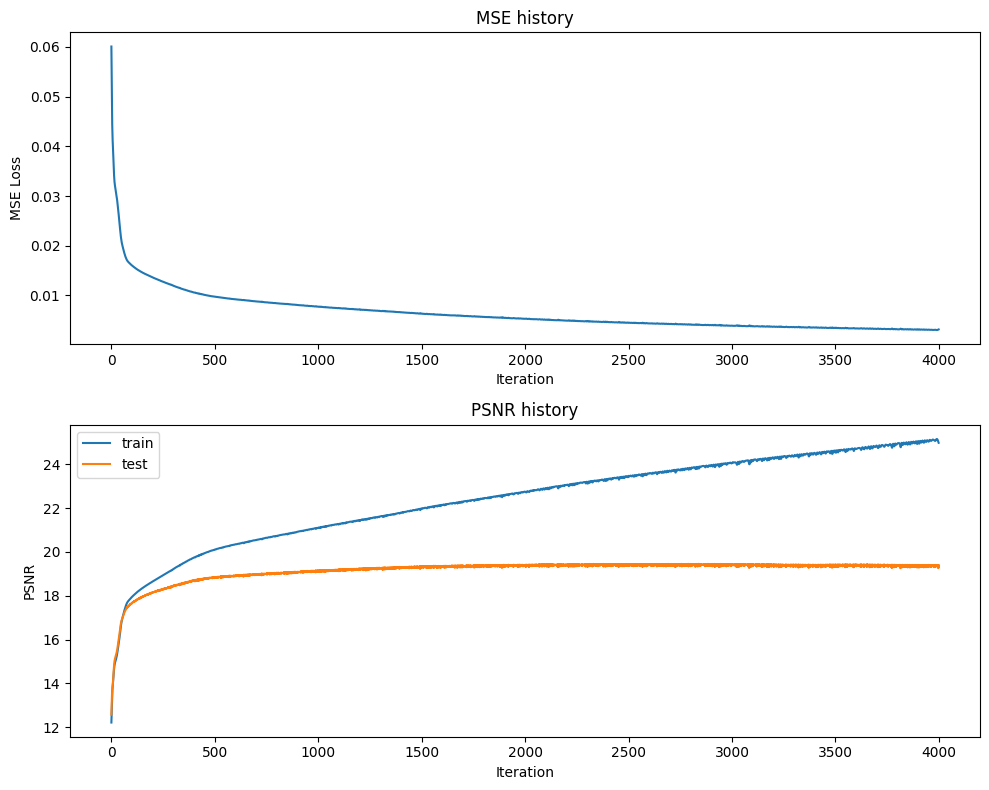

Final Test MSE 0.011490545949806702
Final Test psnr 19.39659336206787


<ipython-input-108-afe762edcc7f>:49: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, N+1, N+1)


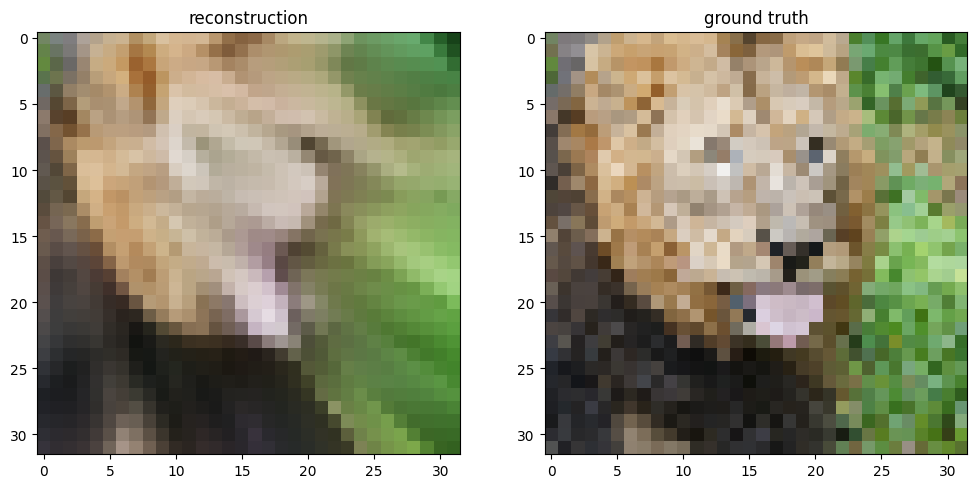

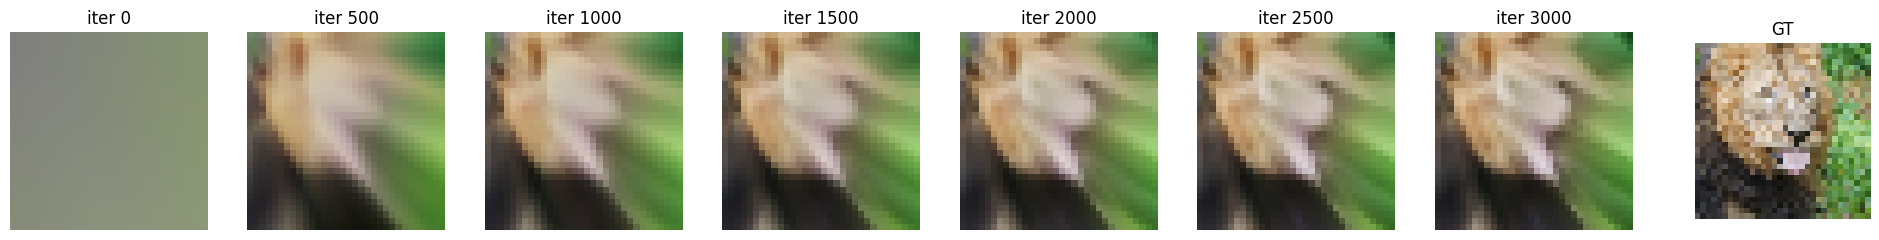

In [ ]:
b_dict = get_B_dict(size)
X_train, y_train, X_test, y_test = get_input_features(b_dict, "none")
# run NN experiment on input features

net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, X_train.shape[1], num_layers, hidden_size, hidden_sizes, 3, 4000, learning_rate = 3e-4, opt="Adam")
# plot results of experiment
plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

#### Low Resolution Reconstruction - Optimizer of your Choice - Various Input Mapping Stategies

In [ ]:
def train_wrapper(mapping, size, opt):
  # makes it easy to run all your mapping experiments in a for loop
  # this will similar to what you did previously in the last two sections
  b_dict = get_B_dict(size)
  X_train, y_train, X_test, y_test = get_input_features(b_dict, mapping)
  net, train_psnrs, test_psnrs, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, X_train.shape[1], num_layers, hidden_size, hidden_sizes, 3, 3000, learning_rate = 0.01, opt=opt)
  return {
      'net': net,
      'train_psnrs': train_psnrs,
      'test_psnrs': test_psnrs,
      'train_loss': train_loss,
      'pred_imgs': predicted_images
  }

In [ ]:
outputs = {}
opt = "SGD"
for k in tqdm(B_dict):
  print("training", k)
  outputs[k] = train_wrapper(k, size, opt)

  0%|          | 0/3 [00:00<?, ?it/s]

training none


  0%|          | 0/3000 [00:00<?, ?it/s]

training basic


  0%|          | 0/3000 [00:00<?, ?it/s]

training gauss_1.0


  0%|          | 0/3000 [00:00<?, ?it/s]

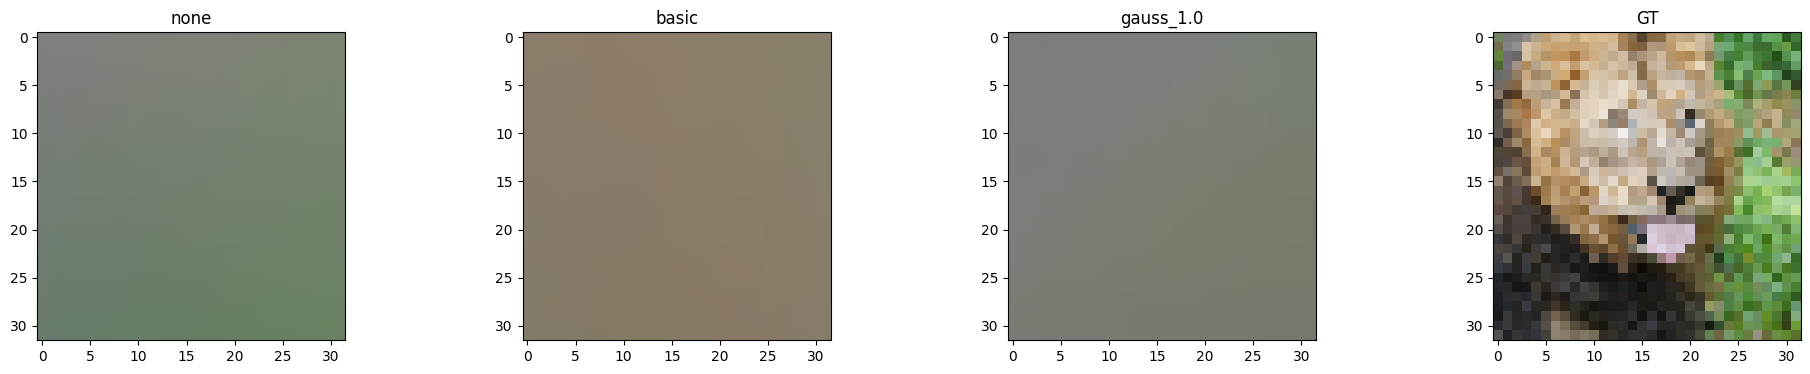

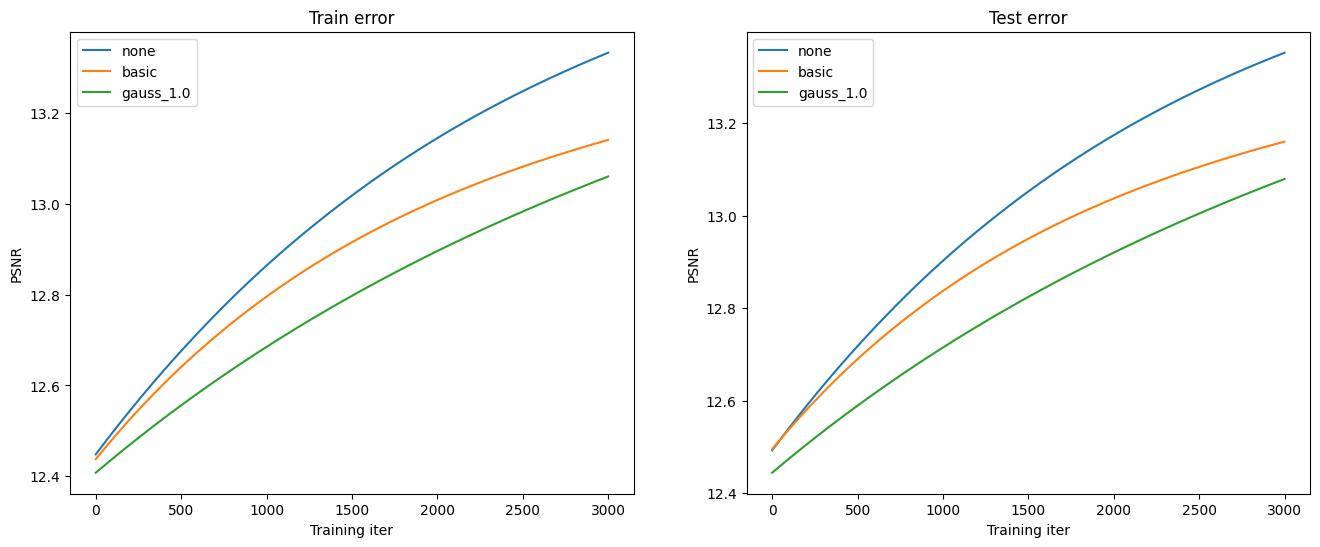

Final PNRS:  13.352513554452587 13.16027441144934 13.079553450592217
Max PNRS:  13.352513554452587 13.16027441144934 13.079553450592217


In [ ]:
b_dict = get_B_dict(size)
X_train, y_train, X_test, y_test = get_input_features(b_dict, "none")
plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))
print("Final PNRS: ", outputs['none']["test_psnrs"][-1], outputs['basic']["test_psnrs"][-1], outputs['gauss_1.0']["test_psnrs"][-1])
print("Max PNRS: ", np.max(outputs['none']["test_psnrs"]), np.max(outputs['basic']["test_psnrs"]), np.max(outputs['gauss_1.0']["test_psnrs"]))


num_layers = 10
hidden_size = 256
hidden_sizes = [hidden_size] * (num_layers - 1)
epochs = 1000
learning_rate = 1e-2
output_size = 3

# High Resolution Reconstruction

#### High Resolution Reconstruction

<ipython-input-39-47d50880e2e8>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


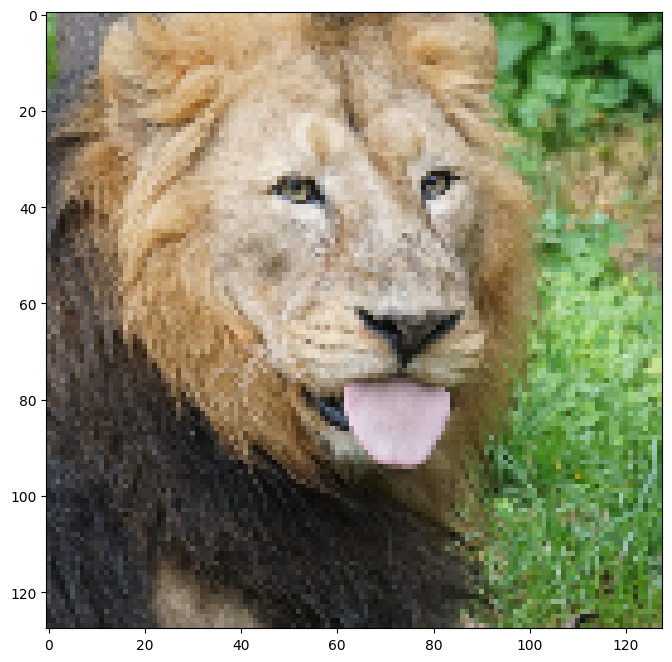

In [ ]:
size = 128
train_data, test_data = get_image(size)

In [ ]:
outputs = {}
for k in tqdm(B_dict):
  print("training", k)
  outputs[k] = train_wrapper(k, size, opt = "Adam")

  0%|          | 0/3 [00:00<?, ?it/s]

training none


  0%|          | 0/3000 [00:00<?, ?it/s]

training basic


  0%|          | 0/3000 [00:00<?, ?it/s]

training gauss_1.0


  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
y_test = test_data[1].reshape(-1, output_size)

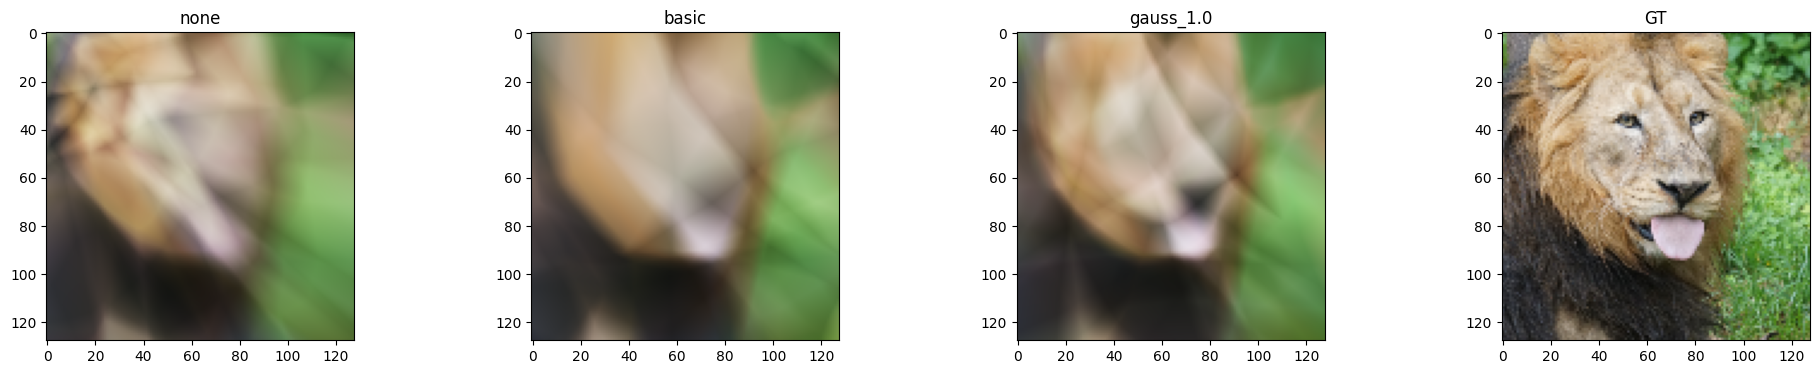

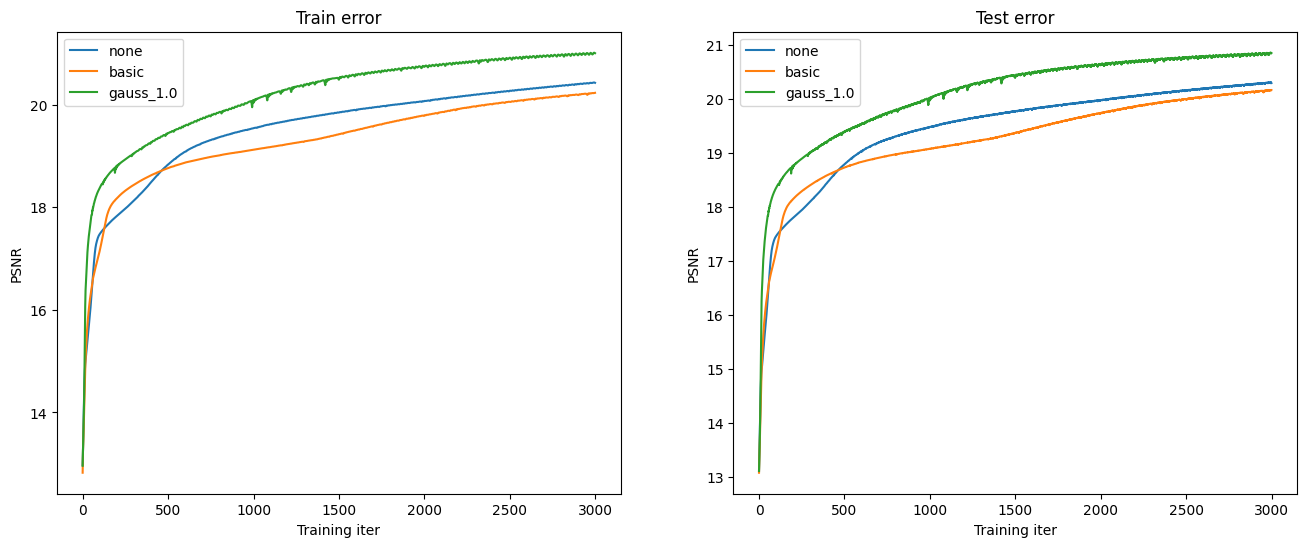

In [ ]:

plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

  0%|          | 0/1500 [00:00<?, ?it/s]

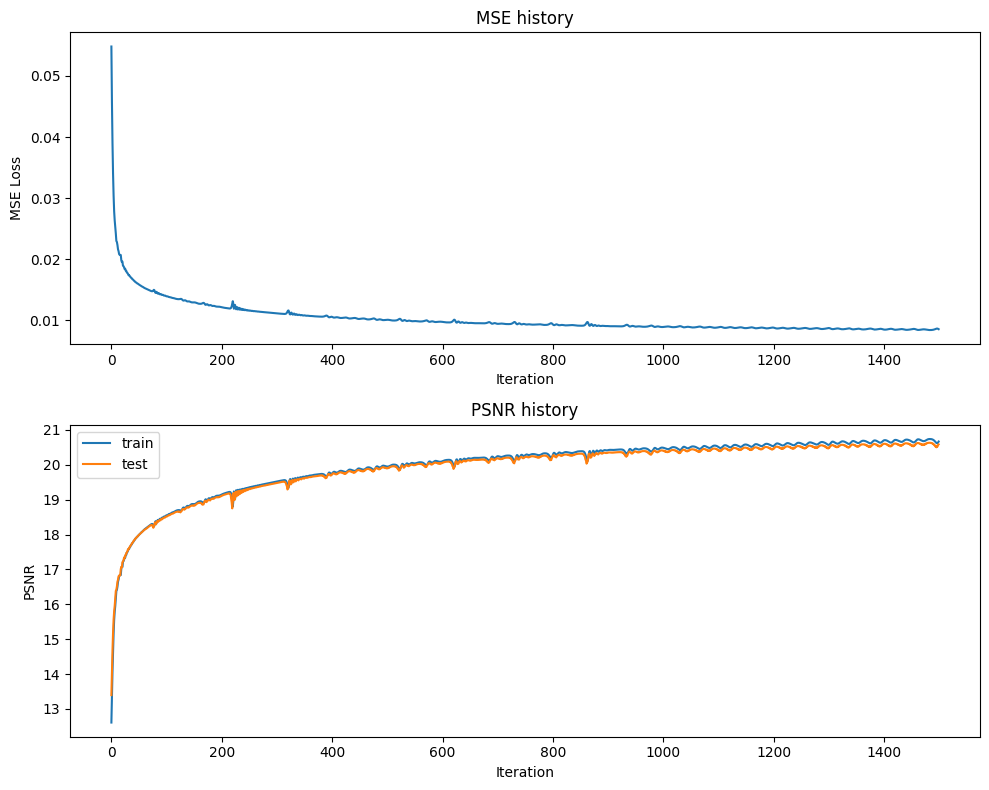

Final Test MSE 0.008738125818618558
Final Test psnr 20.585817062574453


ValueError: num must be an integer with 1 <= num <= 8, not 9

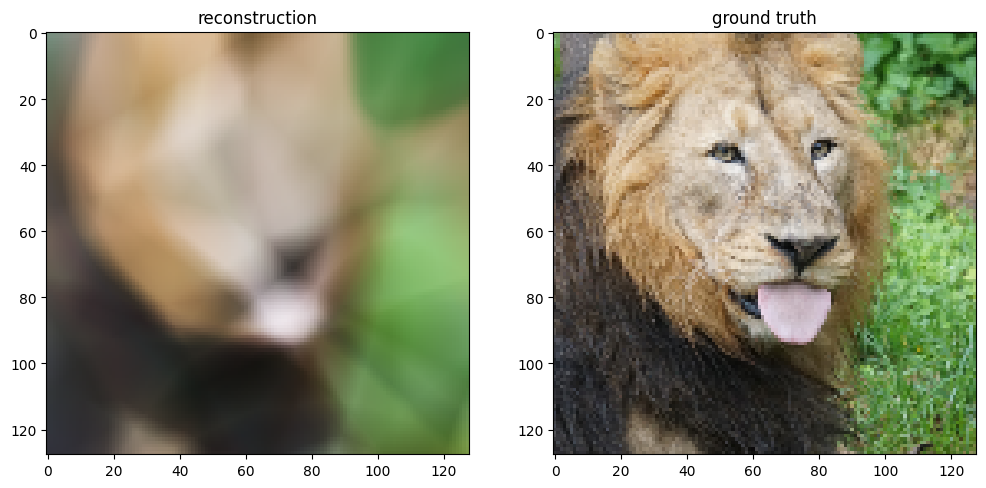

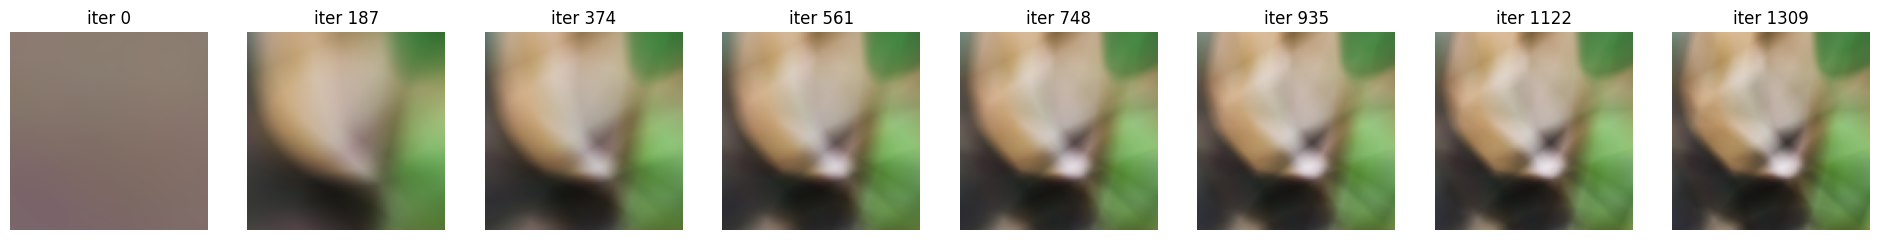

In [ ]:

b_dict = get_B_dict(size)
X_train, y_train, X_test, y_test = get_input_features(b_dict, "gauss_1.0")
# run NN experiment on input features
net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, X_train.shape[1], num_layers, hidden_size, hidden_sizes, 3, 1500, learning_rate = 3e-4, opt="Adam")
# plot results of experiment
plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

#### High Resolution Reconstruction - Image of your Choice

When choosing an image select one that you think will give you interesting results or a better insight into the performance of different feature mappings and explain why in your report template.

<ipython-input-108-47d50880e2e8>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


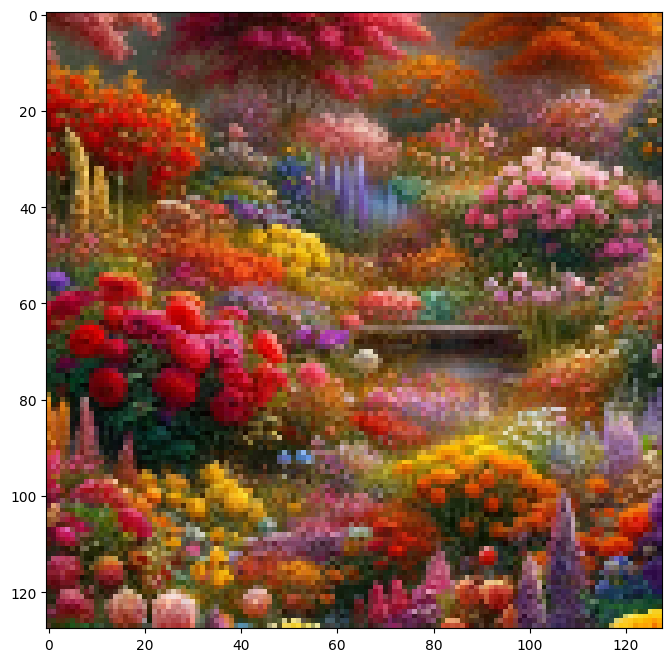

In [ ]:
size = 128
# TODO pick an image and replace the url string
train_data, test_data = get_image(size, image_url="/content/drive/MyDrive/Colab Notebooks/CS444/assignment2/models/vibrant_garden.png")

  0%|          | 0/1500 [00:00<?, ?it/s]

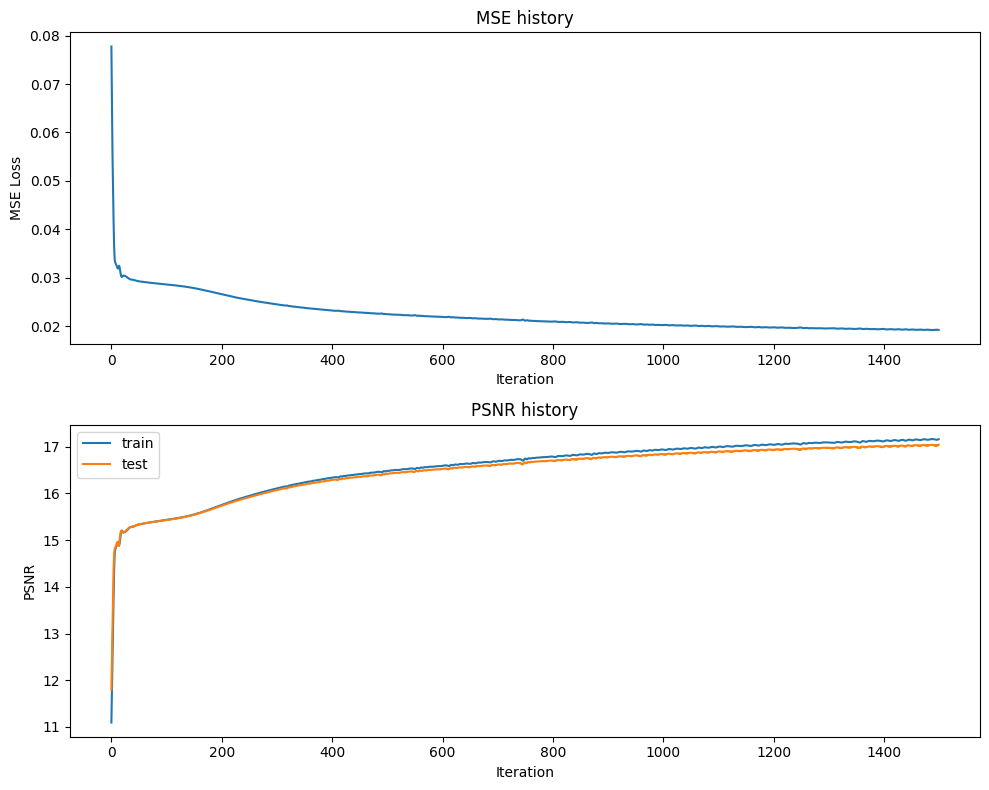

Final Test MSE 0.019750532433079015
Final Test psnr 17.044211922080834


ValueError: num must be an integer with 1 <= num <= 8, not 9

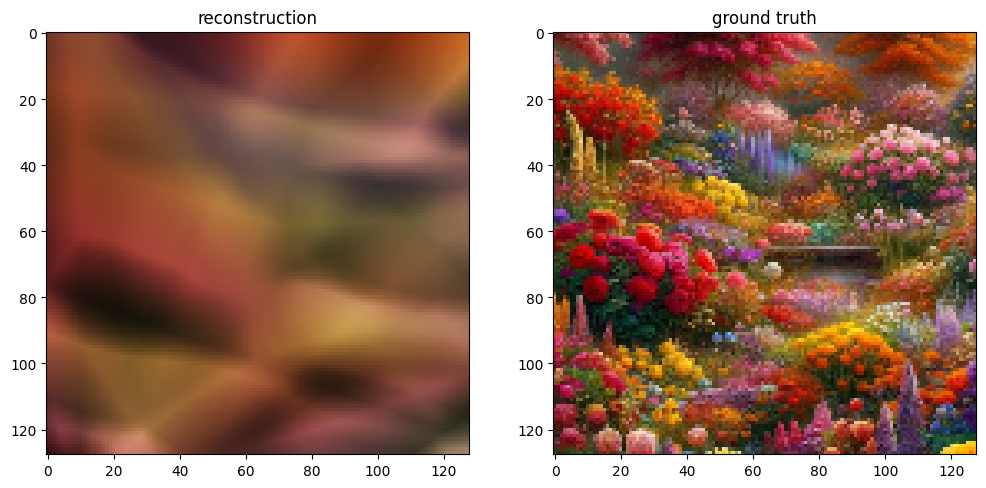

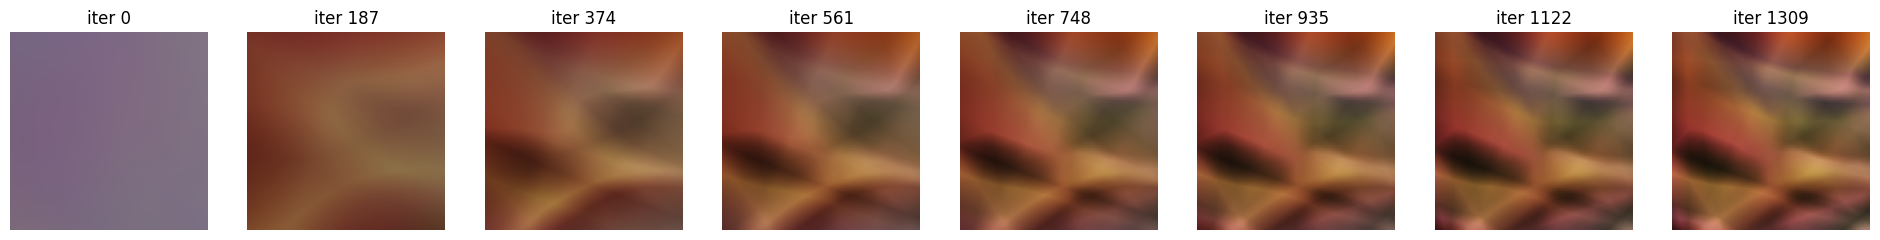

In [ ]:
b_dict = get_B_dict(size)
X_train, y_train, X_test, y_test = get_input_features(b_dict, "gauss_1.0")
# run NN experiment on input features

net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, X_train.shape[1], num_layers, hidden_size, hidden_sizes, 3, 1500, learning_rate = 3e-4, opt="Adam")
# plot results of experiment

plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)